In [2]:
import os
HOUSING_PATH = os.path.join("datasets","housing") # Defines a path in the folder where I'm currently working in
import pandas as pd # Delivers a panda-DataFrame-Object with all data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()


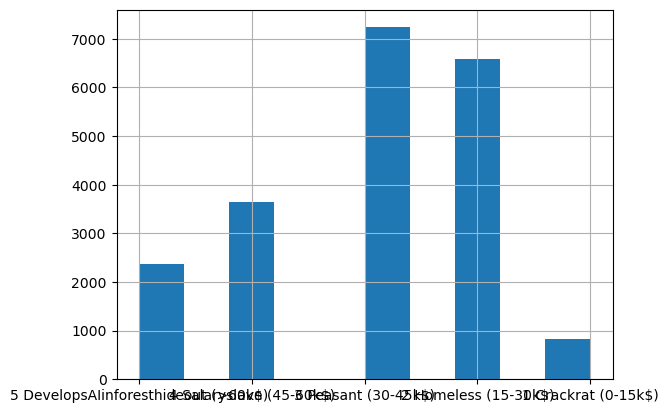

In [3]:
"Stratify our median incomes into income categories"
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6., np.inf], labels=["1 Crackrat (0-15k$)","2 Homeless (15-30k$)","3 Peasant (30-45k$)","4 Salaryslave (45-60k$)","5 DevelopsAIinforesthideout (>60k$)"])
housing["income_cat"].hist()
# Based on our income categories, we apply a SSS to avoid bias in our small test set
from sklearn.model_selection import StratifiedShuffleSplit
SS_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in SS_split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [4]:
# The proportions of the income_cat groups are defined as the following fractions
total_value_counts = housing["income_cat"].value_counts() / len(housing)
strat_test_value_counts = strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

# Convert the Series object to a DataFrame with appropriate column names
df_comparison = pd.DataFrame({
    "Income Category": total_value_counts.index,
    "Normal Proportion": total_value_counts.values,
    "Strat Test Proportion": strat_test_value_counts.values,
})
print(df_comparison)

# After using the stratisfyer category, we shall delete it from our train and test sets to avoid influence on our further procedure
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

                       Income Category  Normal Proportion  \
0                  3 Peasant (30-45k$)           0.350581   
1                 2 Homeless (15-30k$)           0.318847   
2              4 Salaryslave (45-60k$)           0.176308   
3  5 DevelopsAIinforesthideout (>60k$)           0.114438   
4                  1 Crackrat (0-15k$)           0.039826   

   Strat Test Proportion  
0               0.350533  
1               0.318798  
2               0.176357  
3               0.114341  
4               0.039971  


In [15]:
# Searching for useful correlation in the data
corr_matrix = strat_train_set.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))
# Create a heatmap using the DataFrame


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


In [17]:
# Separating the labels from the train set
X_train = strat_train_set.drop("median_house_value",axis=1)
y_train = strat_train_set["median_house_value"].copy()
# Creating numerical trainset for our Simple Imputer
X_num = X_train.drop("ocean_proximity",axis=1)

In [20]:
X_num

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [21]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_num = imputer.fit_transform(X_num) # Fitting the Imputer instance to the data set

X_num = pd.DataFrame(X_num, columns=X_train.drop("ocean_proximity",axis=1).columns, index=X_train.index)

trainset_opcat = X_train[["ocean_proximity"]]

print(trainset_opcat) 
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()
housing_cat_1hot = OHE.fit_transform(trainset_opcat)
print(housing_cat_1hot.toarray())

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
...               ...
15174       <1H OCEAN
12661          INLAND
19263       <1H OCEAN
19140       <1H OCEAN
19773          INLAND

[16512 rows x 1 columns]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [22]:
"""Definition of Own Transformer"""
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
        population_per_household = X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [24]:
# Pipeline for automatic data transformation
# Output is basically all we did before, but faster
# Tranforms all numerical values into the Standard-Derivation form
# Tranforms all categorical values into a OneHot-Matrix
# type(housing_prepared) = numpy.ndarray !
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler",StandardScaler())    
])
housing_num_tr = num_pipeline.fit_transform(X_num)

from sklearn.compose import ColumnTransformer

num_attribs = list(X_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat", OneHotEncoder(),cat_attribs)
])
X_prepared = full_pipeline.fit_transform(X_train)

In [33]:
"""Support Vector Regression"""
"""Systematic Search For Hyperparameters: Grid Search"""
from sklearn.model_selection import GridSearchCV as GS
from sklearn.svm import SVR

svr = SVR()

param_grid = [
    {"kernel":['linear'],"C":[40,50,60,70,80,100]}
]

grid_search = GS(svr,
                 param_grid,
                 cv=3,
                 scoring="neg_mean_squared_error",
                 return_train_score=True
)

grid_search.fit(X_prepared,y_train) # Takes a while >3min
best_parameters = grid_search.best_params_
print("Best Par: ", best_parameters)
best_estimator = grid_search.best_estimator_
print("Best Est: ",best_estimator)
cvres = grid_search.cv_results_
for mean_score, params in zip (cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

Best Par:  {'C': 100, 'kernel': 'linear'}
Best Est:  SVR(C=100, kernel='linear')
74974.75609233239 {'C': 40, 'kernel': 'linear'}
74001.00619098038 {'C': 50, 'kernel': 'linear'}
73345.96924504881 {'C': 60, 'kernel': 'linear'}
72868.81231703966 {'C': 70, 'kernel': 'linear'}
72554.14726708234 {'C': 80, 'kernel': 'linear'}
72134.461671831 {'C': 100, 'kernel': 'linear'}


In [ ]:
"""Feature Importance"""
feature_importances = grid_search.best_estimator_.feature_importances_
print("Default : ", feature_importances)
extra_attribs = ["rooms_per_hhld","population_per_hhld","bedrooms_per_room"]
cat_encoder1 = full_pipeline.named_transformers_["cat"]
cat_1hot_attribs = list(cat_encoder1.categories_[0])
attributes1 = num_attribs + extra_attribs + cat_1hot_attribs
print("")

resultz = sorted(zip(feature_importances, attributes1), reverse=True)
for importance, attribute in resultz:
    print(f"Importance: {importance}, Attribute: {attribute}")

In [35]:
"""Evaluation on Test Data"""
from sklearn.metrics import mean_squared_error as mse 

final_model = grid_search.best_estimator_
print("Model used: ", final_model)

X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

y_pred = pd.Series(final_model.predict(X_test_prepared))

final_rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE :",final_rmse)


Model used:  SVR(C=100, kernel='linear')
RMSE : 69499.58221771539


In [36]:
from scipy import stats
confidence = 0.95
y_pred1 = y_pred.reset_index(drop=True)
y_test1 = y_test.reset_index(drop=True)
squared_errors = (y_pred1 - y_test1) ** 2
interval = np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

"The confidence level specified in the function is 0.95,"
print(f"There is a 95% probability that the true mean squared error is between {round(interval[0],0)} and {round(interval[1],0)}.")
interval


There is a 95% probability that the true mean squared error is between 67011.0 and 71902.0.


array([67011.23772994, 71901.86280463])